In [64]:
import spacy
import json
import en_core_web_sm
import pandas as pd
import numpy as np
import matplotlib
import statistics
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from os import path
%matplotlib inline

In [65]:
with open("../src/data/data_jmlr_vol13-21.json") as f:
    data = json.load(f)
df_data = pd.io.json.json_normalize(data['papers'])
df_data_copy = pd.io.json.json_normalize(data['papers'])

In [66]:
output_directory = "../milestone/images/"

In [67]:
print("no of scraped research papers is {}".format(len(df_data)))

no of scraped research papers is 1261


In [68]:
no_keywords = [len(keyword) for keyword in df_data["keywords"]]

print("the average no of keywords pro research paper is {}".format(statistics.mean(no_keywords)))

the average no of keywords pro research paper is 3.471847739888977


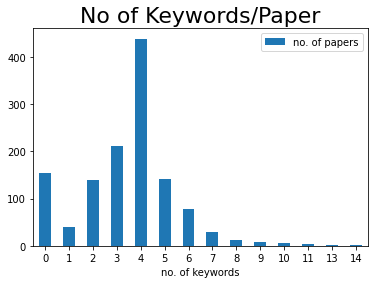

In [69]:
x = list(set(no_keywords))
_ = [no_keywords.count(tmp) for tmp in x]
df = pd.DataFrame({'no. of keywords': x, 'no. of papers':_})
ax = df.plot.bar(x='no. of keywords', y='no. of papers', rot=0)
plt.title("No of Keywords/Paper", fontsize=22)
plt.savefig(Path(output_directory + 'keywords.png'))

In [70]:
mask = [n == 0 for n in no_keywords]
no_of_papers_without_keywords = len(df_data["keywords"][mask])
print("{} papers have no keywords".format(no_of_papers_without_keywords))

153 papers have no keywords


In [71]:
no_words = [len(abstract.split(" ")) for abstract in df_data["abstract"]]

In [72]:
mask = [n == 1 for n in no_words]
no_of_papers_without_abstract = len(df_data["abstract"][mask])

print("{} papers have no keywords".format(no_of_papers_without_abstract))

36 papers have no keywords


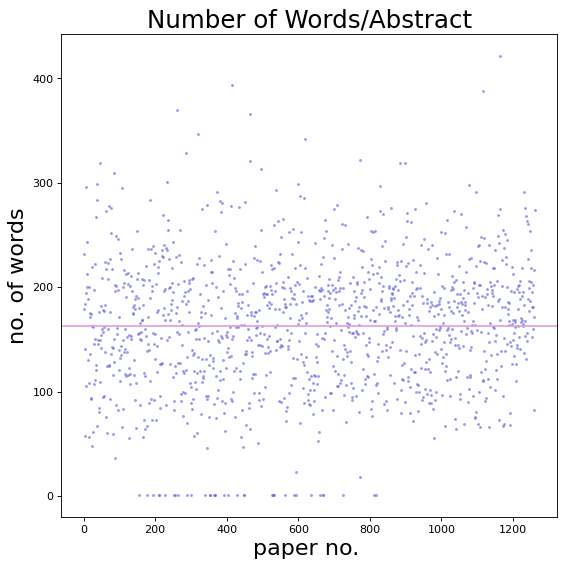

In [73]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(range(1, 1262), no_words, s=3, marker='o', edgecolor='mediumslateblue', cmap='purple', linewidth=1, alpha = 0.5)
plt.title("Number of Words/Abstract", fontsize=22)
plt.xlabel('paper no. ',fontsize=20)
plt.ylabel('no. of words', fontsize=20)
plt.axhline(statistics.mean(no_words),color='plum',ls='-')
plt.savefig(Path(output_directory + 'abstract_words.png'))

In [74]:
df_data.dropna(subset=["keywords"], inplace=True)

nlp = en_core_web_sm.load(disable = ['ner', 'tagger', 'parser'])

stopwords = nlp.Defaults.stop_words

def preprocess_text(text):
    filtered = [token.lower() for token in text]
    filtered = [token for token in filtered if len(token) > 1 and token not in stopwords]
    return filtered

df_data["keywords"] = df_data["keywords"].apply(preprocess_text)

In [75]:
counter = Counter()
df_data["keywords"].apply(counter.update)
print(counter.most_common(20))

[('reinforcement learning', 45), ('online learning', 35), ('clustering', 33), ('classification', 32), ('machine learning', 28), ('deep learning', 24), ('active learning', 22), ('graphical models', 22), ('sparsity', 21), ('convex optimization', 19), ('model selection', 19), ('neural networks', 17), ('lasso', 17), ('feature selection', 16), ('kernel methods', 16), ('bayesian inference', 16), ('gaussian process', 16), ('gaussian processes', 15), ('causal inference', 15), ('matrix completion', 14)]


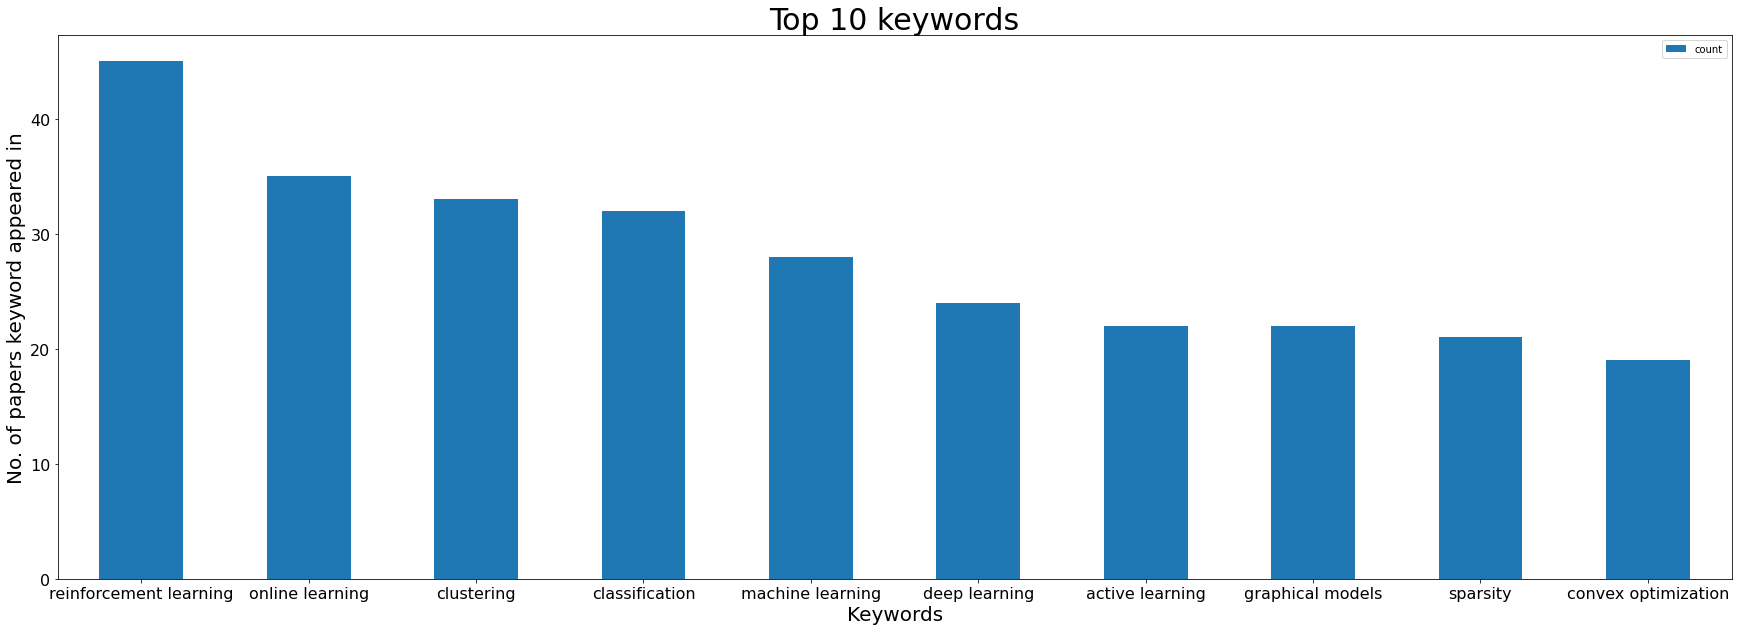

In [76]:
df_counter_words = pd.DataFrame.from_dict(counter, orient='index').reset_index()
df_counter_words = df_counter_words.rename(columns={'index':'word', 0:'count'})
top_words = df_counter_words.nlargest(10, "count")

top_plot = top_words.plot.bar(x='word', y='count', rot=0, fontsize= 16, figsize= (30, 10))
top_plot.set_xlabel("Keywords", fontsize= 20)
top_plot.set_ylabel("No. of papers keyword appeared in", fontsize= 20)
top_plot.set_title("Top 10 keywords", fontsize= 30)
top_plot.yaxis.set_major_formatter(mticker.ScalarFormatter())
top_plot.yaxis.get_major_formatter().set_scientific(False)
plt.savefig(Path(output_directory +"top_keywords.png"))

In [77]:
df_data_copy.dropna(subset=["keywords"], inplace= True)
df_data_copy["keywords"] = df_data_copy["keywords"].apply(preprocess_text)


def count_no_keywords_per_document(text):
    return len(list(set(text).intersection(list(top_words["word"]))))
    
no_of_top_words_per_document = df_data_copy["keywords"].apply(count_no_keywords_per_document)

In [78]:
print("max no. of keywords from top 10 present in a single paper is {}".format(max(no_of_top_words_per_document)))
print("{} papers have 0 keywords from top 10".format(len(no_of_top_words_per_document[no_of_top_words_per_document == 0])))
print("{} papers have 1 keywords from top 10".format(len(no_of_top_words_per_document[no_of_top_words_per_document == 1])))
print("{} papers have 2 keywords from top 10".format(len(no_of_top_words_per_document[no_of_top_words_per_document == 2])))


max no. of keywords from top 10 present in a single paper is 2
996 papers have 0 keywords from top 10
249 papers have 1 keywords from top 10
16 papers have 2 keywords from top 10


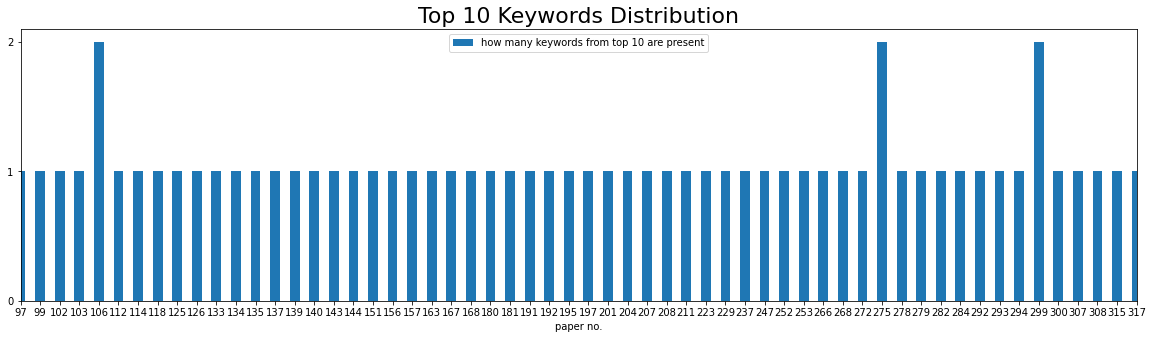

In [79]:
x = []
for indx, val in enumerate(list(no_of_top_words_per_document > 0)):
    if val:
        x.append(indx)
        
df_ = pd.DataFrame({'paper no.': x[25:85], 'how many keywords from top 10 are present':no_of_top_words_per_document[no_of_top_words_per_document > 0][25:85]})
ax = df_.plot.bar(x='paper no.', y='how many keywords from top 10 are present', rot=0, figsize=(20, 5))
plt.title("Top 10 Keywords Distribution", fontsize=22)
tickpos = [0,1,2]
plt.axis(ymin = 0)
plt.yticks(tickpos,tickpos)
plt.xlim(1, 58)

plt.savefig(Path(output_directory + "distribution_keywords.png"))

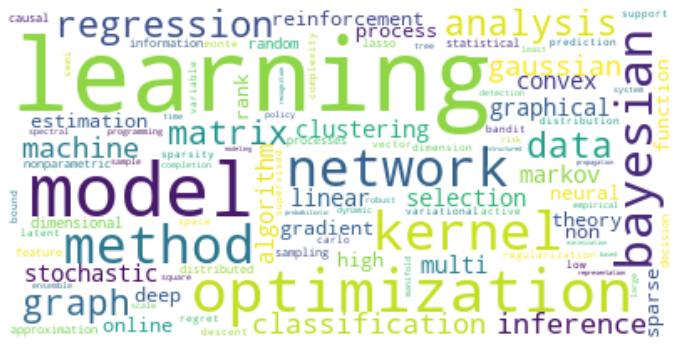

In [80]:
from wordcloud import WordCloud

df_data["keywords"] = df_data["keywords"].str.join(" ")
joined_text = " ".join(df_data.keywords.tolist())

wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white", collocations=False).generate(joined_text)

fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(Path(output_directory + "top_keywords_wordcloud.png"))